In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sn
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

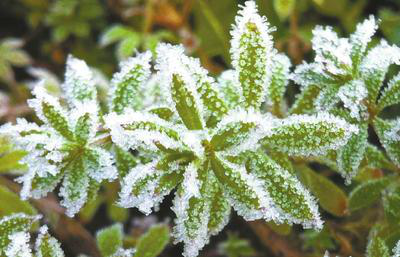

In [3]:
# Open one image from the dataset
path = 'dataset'
with Image.open('dataset/frost/3600.jpg') as img:
    display(img)

In [4]:
# Create ImageFolder Dataset
dataset = datasets.ImageFolder(path, transform=None)
dataset

Dataset ImageFolder
    Number of datapoints: 6862
    Root location: dataset

In [5]:
classes = dataset.classes
print(classes)
print("\t")
print("Number of classes:", len(classes))

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
	
Number of classes: 11


## Split dataset into train, validation and test sets

In [6]:
# Split dataset into train and test
train_size_old = int(0.85 * len(dataset))
test_size = len(dataset) - train_size_old
train_data_old, test_data = torch.utils.data.random_split(dataset, [train_size_old, test_size])

# Split dataset to train and validation
train_size = int(0.85 * len(train_data_old))
validation_size = len(train_data_old) - train_size

train_data, validation_data = torch.utils.data.random_split(train_data_old, [train_size, validation_size])

## Define transforms for each set

In [7]:
# Define the normalization values for mean and standard deviation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Apply transformation mechanism for each set
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
train_data.dataset.transform = train_transform

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
validation_data.dataset.transform = val_transform

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_data.dataset.transform = test_transform

## Create data loaders for each set of data

In [8]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

print("Training images available:", len(train_data))
print("\t")
print("Validation images available:", len(validation_data))
print("\t")
print("Testing images available:", len(test_data))

Training images available 4957
	
Validation images available 875
	
Testing images available 1030


In [9]:
# Show one tensor from train data

train_data[0]

(tensor([[[ 0.7762,  0.7933,  0.7591,  ...,  1.9064,  1.8550,  1.8379],
          [ 0.5364,  0.5707,  0.6734,  ...,  1.9235,  1.8722,  1.8550],
          [ 0.4337,  0.4508,  0.5707,  ...,  1.9407,  1.9064,  1.8722],
          ...,
          [ 0.4166,  0.3823,  0.8276,  ...,  1.4612,  1.3413,  1.2899],
          [ 0.1597,  0.1597,  0.6392,  ...,  1.3242,  1.0673,  1.1187],
          [ 0.3994,  0.3481,  0.6392,  ...,  1.2385,  1.2043,  1.2899]],
 
         [[ 1.2031,  1.2206,  1.1856,  ...,  2.2885,  2.2710,  2.2360],
          [ 0.9580,  0.9930,  1.0980,  ...,  2.2885,  2.2710,  2.2535],
          [ 0.8529,  0.8704,  0.9930,  ...,  2.3060,  2.2710,  2.2710],
          ...,
          [-0.5301, -0.6702, -0.3550,  ...,  1.2031,  0.8880,  0.6954],
          [-0.4251, -0.5126, -0.1450,  ...,  1.5182,  1.0630,  0.9930],
          [ 0.0301, -0.0749,  0.1527,  ...,  1.7633,  1.5882,  1.5532]],
 
         [[ 1.8557,  1.8731,  1.8383,  ...,  2.5703,  2.5703,  2.5529],
          [ 1.6117,  1.6465,

Class Indexes: [9 4 8 0 0 8 4 3 7 8 6 8 9 5 5 1]
	
Sample image size: torch.Size([3, 224, 224])


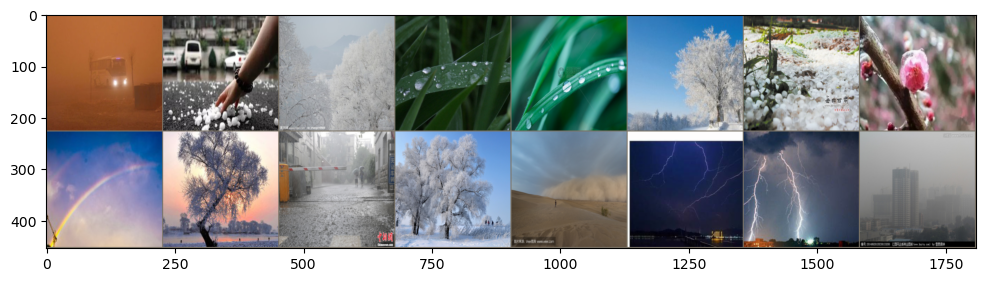

In [10]:
# Grab the first batch of 16 images

for images, labels in train_loader: 
    break

# Print the labels
print('Class Indexes:', labels.numpy())
print("\t")

im = make_grid(images, nrow=8)

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Check one image shape
print("Sample image size:", images[10].shape)

## Define the Convolutional Network (model)

In [11]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 11)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 54*54*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# (((224−2)/2)−2)/2 = 54.5 which rounds down to 54 pixels per side.

In [12]:
# Instantiate the model, define loss and optimization functions

CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(CNNmodel.parameters(), lr=0.001)
print(CNNmodel)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=11, bias=True)
)


In [13]:
# Looking at the trainable parameters
# sum of waits in whole CNN model

def count_parameters(model):
    print("Sum of waits of the model:")
    print("\t")
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
    
count_parameters(CNNmodel)

Sum of waits of the model:
	
     162
       6
     864
      16
 5598720
     120
   10080
      84
     924
      11
________
 5610987


## Train the model

In [14]:
start_time = time.time()
epochs = 11

train_losses = []
train_correct = []
validation_losses = []
validation_correct = []

for epoch in range(epochs):
    train_corr = 0
    validation_corr = 0
    
    # Run the training batches
    for batch, (x_train, y_train) in enumerate(train_loader):

        # Apply the model for training
        outputs = CNNmodel(x_train)
        loss = criterion(outputs, y_train)
 
        # number of correct predictions
        predicted = torch.max(outputs.data, 1)[1]
        train_corr += (predicted == y_train).sum()
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss)
    train_correct.append(train_corr)
    
    # Print each epoch results
    print(" Epoch:", epoch + 1, " Loss:", round(loss.item(), 5), 
          "Train accuracy:", round(train_corr.item() * 100 / (batch * 16), 3), "%")


    
    
    # Run the validation batches
    CNNmodel.eval()
    
    with torch.no_grad():
        for batch, (x_validation, y_validation) in enumerate(validation_loader):
            
            # Apply the model for validation
            outputs = CNNmodel(x_validation)
            loss = criterion(outputs, y_validation)

            # number of correct predictions
            predicted = torch.max(outputs.data, 1)[1] 
            validation_corr += (predicted == y_validation).sum()
            
    validation_losses.append(loss)
    validation_correct.append(validation_corr)
    
    
print("\t")
print("Duration:", round(time.time() - start_time, 1), "seconds")

 Epoch: 1  Loss: 1.5706 Train accuracy: 53.803 %
 Epoch: 2  Loss: 0.92642 Train accuracy: 70.105 %
 Epoch: 3  Loss: 0.33725 Train accuracy: 80.785 %
 Epoch: 4  Loss: 0.11441 Train accuracy: 90.049 %
 Epoch: 5  Loss: 0.13262 Train accuracy: 94.013 %
 Epoch: 6  Loss: 0.04852 Train accuracy: 96.015 %
 Epoch: 7  Loss: 0.08274 Train accuracy: 97.613 %
 Epoch: 8  Loss: 0.05684 Train accuracy: 97.593 %
 Epoch: 9  Loss: 0.1655 Train accuracy: 96.703 %
 Epoch: 10  Loss: 0.1271 Train accuracy: 98.058 %
 Epoch: 11  Loss: 0.0172 Train accuracy: 99.049 %
	
Duration: 1040.3383452892303 seconds


## Evaluate model performance

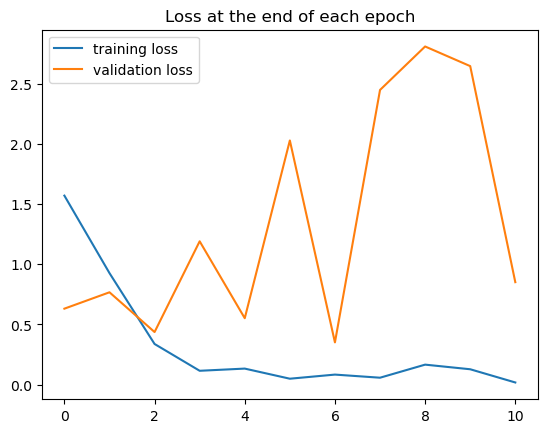

In [15]:
# Plot Losses

plt.plot([t.detach().numpy() for t in train_losses], label='training loss')
plt.plot([t.detach().numpy() for t in validation_losses], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

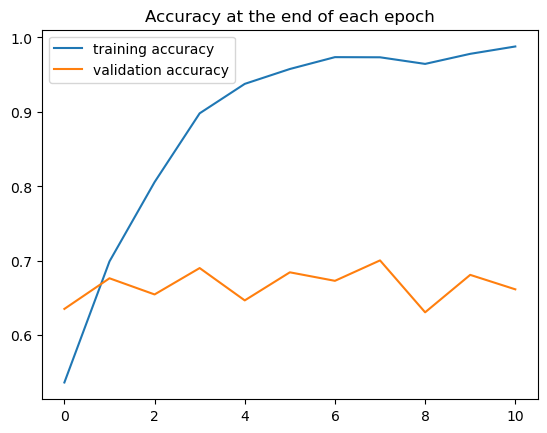

In [16]:
# Plot accuracy

plt.plot([t/4957 for t in train_correct], label='training accuracy')
plt.plot([t/875 for t in validation_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [17]:
# Accuracy of the last epoch for all data

print("Train Correct:", train_correct)
print("Train Accuracy:", round(train_correct[-1].item() * 100 / 4957, 3), "%")

print("\t")

print("Validation Correct:", validation_correct)
print("Validation Accuracy:", round(validation_correct[-1].item() * 100 / 875, 3), "%")

Train Correct: [tensor(2660), tensor(3466), tensor(3994), tensor(4452), tensor(4648), tensor(4747), tensor(4826), tensor(4825), tensor(4781), tensor(4848), tensor(4897)]
Train Accuracy: 98.79 %
	
Validation Correct: [tensor(556), tensor(592), tensor(573), tensor(604), tensor(566), tensor(599), tensor(589), tensor(613), tensor(552), tensor(596), tensor(579)]
Validation Accuracy: 66.171 %


## Test the model

In [18]:
# Test the model
test_losses = []
test_correct = []
test_corr = 0

# Run the test batches
CNNmodel.eval()

with torch.no_grad():
    for batch, (x_test, y_test) in enumerate(test_loader):

        # Apply the model for validation
        outputs = CNNmodel(x_test)
        loss = criterion(outputs, y_test)

        # number of correct predictions
        predicted = torch.max(outputs.data, 1)[1] 
        test_corr += (predicted == y_test).sum()

test_losses.append(loss)
test_correct.append(test_corr)

In [19]:
# Evaluate test data

print("Test Correct:", test_correct)
print("Test Accuracy:", round(test_correct[-1].item() * 100 / 1030, 3), "%")

Test Correct: [tensor(650)]
Test Accuracy: 63.107 %


## Confusion Matrix

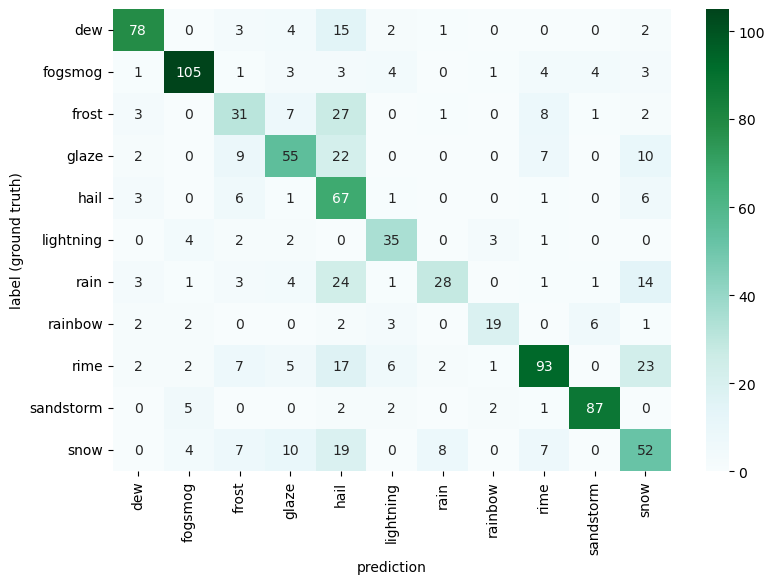

In [20]:
# Create a loader for the entire test set
test_load_all = DataLoader(test_data, batch_size=1030, shuffle=False)

with torch.no_grad():
    correct = 0
    for x_test, y_test in test_load_all:
        outputs = CNNmodel(x_test)
        predicted = torch.max(outputs,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, classes, classes)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

## Open a custom image and use the model for prediction

Custom image size: torch.Size([3, 224, 224])
	
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
	
Predicted Class Index: 7


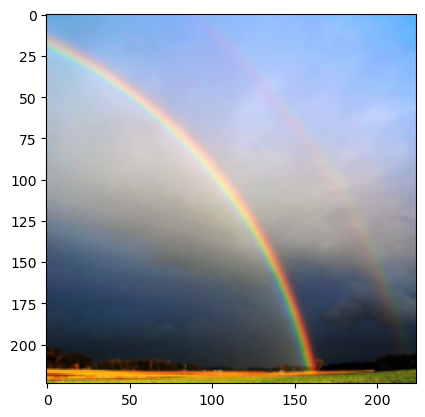

In [21]:
custom_img = Image.open('custom_images/1.jpg')

transform_custom = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

custom_img_t = transform_custom(custom_img)
print("Custom image size:", custom_img_t.shape)
print("\t")

custom_img_n = inv_normalize(custom_img_t)
plt.imshow(np.transpose(custom_img_n.numpy(), (1, 2, 0)));

# CNN Model Prediction:
CNNmodel.eval()
with torch.no_grad():
    custom_pred = CNNmodel(custom_img_t.view(1,3,224,224)).argmax()
    
print("Classes:", classes)
print("\t")
print("Predicted Class Index:", custom_pred.item())